
<img src="ps.png" width="200">

<h1><center>  Show and Tell : A Neural Image Caption Generator </center></h1>

<h3>  <p style="text-align:left;">Authors: <span style="float:right;"> Professors:
    <br> Florence D'ALCHÉ-BUC <br> Slim ESSID<br> Zoltan Szabo<br> <br>
</span></p>

<br> Damien Grasset <br> Alice Guichenez </h3>


**Image Captioning** consits in descibing an image with a sentence. The goal of this notebook is to show step by step how we can construct an Neural Image Caption Generator that takes an image as input and return an english sentence whose aim is to describe what it sees in the image. To do so, we used the methodology and the main ideas from the article *Show and Tell: A Neural Image Caption Generator* by O. Vinyals, A. Toshev *et al*, a team of researchers from Google, and tries to implement it with Keras and the Flikr8k Image Dataset.

# Outline

## <a href="#1.-Flickr8k-Dataset " style="color:#00925B">1.&nbsp;&nbsp;Description and Understanding of the Flickr8k Dataset </a>

## <a href="#2.-A-Neural-Image-Caption-Generator" style="color:#00925B">2.&nbsp;&nbsp;A Neural Image Caption Generator </a>

-  <a href="#1.-Image-Encoder-using-Pre-Trained-CNN-models" style="color:#00925B">2.1.&nbsp;&nbsp;Image Encoder using Pre-Trained CNN models </a>

-  <a href="#2.-LSTM-based-Sentence-Generator" style="color:#00925B">2.2.&nbsp;&nbsp;LSTM-based Sentence Generator </a>

-  <a href="#3.-Model-:-Mixing-all-together" style="color:#00925B">2.3.&nbsp;&nbsp;Model : Mixing all together </a>

## <a href="#3.-Image-Captioning-Results" style="color:#00925B">3.&nbsp;&nbsp;Image Captioning Results </a>

-  <a href="#1.-Strategies" style="color:#00925B">3.1.&nbsp;&nbsp;Decoding Strategies </a>

-  <a href="#2.-Examples" style="color:#00925B">3.2.&nbsp;&nbsp;Examples </a>
-  <a href="#3.-Analysis" style="color:#00925B">3.3.&nbsp;&nbsp;Analysis </a>


## Packages 

In [1]:
import os
import re
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
from imageio import imread
import cv2 as cv

# Keras 
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,  \
                Concatenate, Activation, Flatten, Input, BatchNormalization, Dropout, concatenate
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model



PATH_IMAGES = 'D:/Structured-Data/Flickr_Data/Images'
HOME_PATH = 'D:/Structured-Data/'

Using TensorFlow backend.


# 1. Flickr8k Dataset

We're going to use the Flickr8k datasets (for non-commercial educational purpose only). This dataset contains around 30k images and each of these image is associated with 4 or 5 differents captions, ie sentences that describes the image in engish language.

Let's have a deeper look at this dataset

###  Images and Captions

In [2]:
nb_images = 0
for file in os.listdir(PATH_IMAGES):
    nb_images += int(file.endswith('jpg'))
print('Nb of available images in Flickr30k: ',nb_images)

Nb of available images in Flickr30k:  8091


Let's build a dictionnary which will associate for each image, the corresponding list of 5 sentences describing it.

In [5]:
images_captions = {}

with open('D:/Structured-Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt','rb') as f :
    captions = f.read()
    captions = captions.decode("utf-8")
    f.close
    
for caption in tqdm_notebook(captions.split('\n')):
    if caption == '':
        continue
    image, sentence = caption.split('\t')
    image = image[:-2]
    images_captions[image] = images_captions.get(image,[]) + [sentence]

### Example

Let's look at a random example 

Image ID =  2766726291_b83eb5d315.jpg 
Captions : 
	0. A blond child is drinking from a garden hose .
	1. A boy drinks from the water hose .
	2. A child with a water house to his mouth .
	3. a little boy drinks water from the green hose .
	4. Young boy blows into a hose while sitting on the deck .


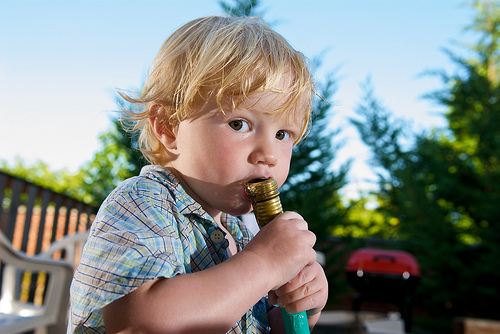

In [6]:
id_img = list(images_captions.keys())[np.random.randint(nb_images)]
print('Image ID = ', id_img, '\nCaptions : ')
for i,caption in enumerate(images_captions[id_img]):
    print('\t{}. {}'.format(i, caption))
ipd.Image(os.path.join(PATH_IMAGES, id_img))

### Processing of Images

All images don't have the same dimension and a normalization will be thus needed. We will proceed with the following steps : 
- Rescale pictures to 224x224x3 pictures (keeping colors)
- Normalized values between -1 and 1 (ie applying the follwing transformation $f(x)=(\frac{x}{255} - 0.5 )*2$

In [7]:
from keras.preprocessing import image

def image_processing(path, normalized = False):
    #img = cv.imread(path)
    #res = cv.resize(img,dsize=(224, 224), interpolation =cv.INTER_AREA  )
    #res = res[np.newaxis,:]
    res = image.load_img(path, target_size=(224, 224))
    if normalized :
        res = res/255.
        res -= 0.5
        res *= 2.
    return res

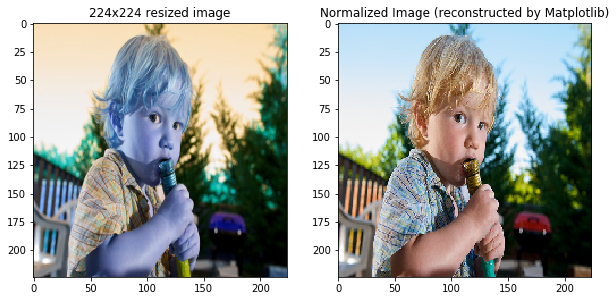

In [8]:
img_array = imread(os.path.join(PATH_IMAGES, id_img))

img = cv.imread(os.path.join(PATH_IMAGES, id_img))
res = cv.resize(img,dsize=(224, 224), interpolation =cv.INTER_AREA  )

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('224x224 resized image')
plt.imshow(np.squeeze(res))
plt.subplot(122)
plt.title('Normalized Image (reconstructed by Matplotlib)')
plt.imshow(np.squeeze(image_processing(os.path.join(PATH_IMAGES, id_img))))

Now we have processed the images, we're going to split the dataset bewteen a Train and a Test folder.

### Train-Test Split

In [14]:
from random import shuffle
np.random.seed(12)

images = list(sorted(images_captions.keys()))
shuffle(images)

with open('D:/Structured-Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt','r') as f:
    train_images = f.read().split('\n')
    f.close()
    
with open('D:/Structured-Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt','r') as f:
    test_images = f.read().split('\n')
    f.close()

#train_images, test_images = images[:int(len(images)*0.7)+1], images[int(len(images)*0.7)+1:]
print('Ratio of Training Images ',len(train_images)/len(images))

Ratio of Training Images  0.7415966386554622


# 2. A Neural Image Caption Generator

![model.png](model.png)

## 1. Image Encoder using Pre Trained CNN models

The First step of our **image caption generator** is to encode images using a CNN models. To do so, we'll use pre-trained weights of the **InceptionV3** model trained on the ImageNet database. This CNN architecture whose weights will be frozen will be used to encode 224x224x3 images to vectors of fixed-size (1,4800).  Keras makes the use of these pre-trained weights very easy. 

Hence, once the weithgs loaded, we'll keep all layers but the two last ones. This is needed as the InceptionV3 is originally composed of a last dense and sofmax layers trained to be used in a classification task. We'll just take benefit of vectors right before those two last layers. The main idea is that the CNN Architecture will capture some interesting features on the images and we'll take benefit from this for our own task.

In [ ]:
from keras.applications import InceptionV3

image_size = 224
imagnet_conv = InceptionV3(weights='imagenet', include_top=True, input_shape=(image_size, image_size, 3))
cnn_encoder = Model(inputs=imagnet_conv.input,  outputs=imagnet_conv.layers[-2].output)

One might be interesting to look closer at the CNN Architerure used here : 
```python
cnn_encoder.summary() ```

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

def image_processing(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode_image(cnn_encoder, path_image, path_encoding):
    encoded_image = cnn_encoder.predict(image_processing(path_image))
    np.save(path_encoding, encoded_image)

In [ ]:
def encode_image_batch(cnn_encoder, path_images, path_encodings):
    mat = image_processing(path_images[0])
    for path_image in path_images[1:] :
        mat = np.concatenate([mat,image_processing(path_image)], axis=0)
    encoded_images = cnn_encoder.predict(mat)
    for i in range(encoded_images.shape[0]) :
        encoded_image = encoded_images[i]
        path_encoding = path_encodings[i]
        np.save(path_encoding, encoded_image)

Once we've loaded the **cnn_encoder**, we'll use it right now to encode all images we have. As :
- every image will need to be encoded at some point
- we won't re-train the cnn weights
- and during training, we'll re-use the encoded images several time,

We'll save some time by doing the encoding of the images before (we'll save some RAM memory storage as well to do it before). Hence, we'll save into a ``` Train``` and  ``` Test ``` folders, images according to the split we did previously

In [ ]:
HOME_PATH = 'D:/Structured-Data/'

if not os.path.exists(os.path.join(HOME_PATH, 'Encoded_Train')):
    os.mkdir(os.path.join(HOME_PATH, 'Encoded_Train'))

if not os.path.exists(os.path.join(HOME_PATH, 'Encoded_Test')):
    os.mkdir(os.path.join(HOME_PATH, 'Encoded_Test'))

for img in tqdm_notebook(train_imgs_id): 
    path_to_image = os.path.join(images,str(img))
    path_encoded_image  = os.path.join("Encoded_Train",str(img)[:-3]+'npy')
    encode_image(path_to_image, path_encoded_image)


In [ ]:
# path_to_images = []
# path_to_encoded_images = []

#By Batch of 64
# for train_image in tqdm_notebook(train_images) : 
#     path_to_encoded_image = os.path.join(HOME_PATH, 'Encoded_Train', train_image[:-3]+'npy')
#     if not os.path.exists(path_to_encoded_image):
#         path_to_image = os.path.join(PATH_IMAGES, train_image)
#         path_to_images.append(path_to_image)
#         path_to_encoded_images.append(path_to_encoded_image)
#         if len(path_to_images)%64 == 0:
#             encode_image_batch(cnn_encoder, path_to_images, path_to_encoded_images)
#             path_to_images =[]
#             path_to_encoded_images=[]
            
# for test_image in tqdm_notebook(test_images) : 
#     path_to_image = os.path.join(PATH_IMAGES, test_image)
#     path_to_encoded_image = os.path.join(HOME_PATH, 'Encoded_Test', test_image[:-3]+'npy')
#     if not os.path.exists(path_to_encoded_image):
#         encode_image(cnn_encoder, path_to_image, path_to_encoded_image)

In [ ]:
cnn_encoder.predict(image_processing(os.path.join(PATH_IMAGES, id_img))).flatten().shape

## 2. LSTM-based Sentence Generator

Now, let's focus on the LSTM part of the Architecture.

First task, we need to process captions, ie the sentences linked to images. To do so, we'll :
 - build the vocabulary of all words in the dataset.
 - add ```<start> ``` and  ```<end> ``` markers at the beginning and end of each sentence. 
 - transform sentences into vectors using one-hot encoding of words with respect to the vocabulary.

The step of adding  ```<start> ``` and  ```<end> ``` markers is crucial. It will first allow the Sentence Generator to understand weither a sentence is starting, ie it will try to predict the next/first words from an image only (and an empty context). Then it will allow the model to predict the end of the sentence (and stop generating words) by predicting this specific marker.

### Sentences

In [15]:
for image, sentences in tqdm_notebook(images_captions.items()):
    sentences_marked = []
    for sentence in sentences:
        
        sentence = sentence.lower()
        sentence = re.sub(r'[^a-z0-9.]', ' ', sentence)
        sentence = re.sub(r' +',' ', sentence)

        
        sentence = '<start> ' + sentence
        if sentence[-1] == '.' and sentence[-2] != ' ' :
            sentences_marked.append(sentence[:-1] + ' <end>')
        
        elif sentence[-1] != '.':
            sentences_marked.append(sentence.strip() + ' <end>')
        
        else : 
            sentences_marked.append(sentence[:-1] + '<end>')
            
    
    images_captions[image] = sentences_marked

In [16]:
images_captions[id_img]

['<start> a blond child is drinking from a garden hose <end>',
 '<start> a boy drinks from the water hose <end>',
 '<start> a child with a water house to his mouth <end>',
 '<start> a little boy drinks water from the green hose <end>',
 '<start> young boy blows into a hose while sitting on the deck <end>']

In [17]:
caps = []
for image, sentences in images_captions.items():
    for sentence in sentences:
        caps.append(sentence)
        
unique_words = np.unique(str.join(' ', caps).split(' '))

vocab_size = len(unique_words)
print('Nb of unique word in the vocabulary :',vocab_size)

Nb of unique word in the vocabulary : 8492


In [19]:
from collections import Counter 
c = Counter(str.join(' ', caps).split(' '))
unique_words = [word for word, occ in c.items() if occ > 2]
vocab_size = len(unique_words)
print('Final Vocabulary :',vocab_size)

Final Vocabulary : 4076


In [20]:
for image, sentences in tqdm_notebook(images_captions.items()):
    sentences_filtered = []
    for sentence in sentences:
        try : 
            assert sentence.startswith('<start>') and sentence.endswith('<end>')
        except : 
            print(sentence)
        sentence = re.sub(r' +', ' ', sentence)
        sentence = sentence.split(' ')
        sentence = [word for word in sentence if word in unique_words]
        if len(sentence) >= 5 : 
            sentences_filtered.append(str.join(' ',sentence))
        else : 
            #print(sentence)
            pass
    images_captions[image] = sentences_filtered

In [21]:
for image, sentences in tqdm_notebook(images_captions.items()):
    for sentence in sentences:
        try : 
            assert sentence.startswith('<start>') and sentence.endswith('<end>')
        except : 
            print(sentence)

We'll need a mapping in both direction if we want to be able to decode outputs of the generator into real english sentences as well.

In [22]:
word2idx = {val:index for index, val in enumerate(unique_words)}
idx2word = {index:val for index, val in enumerate(unique_words)}

In [23]:
word2idx['<end>'], idx2word[0]

(14, '<start>')

In [30]:
files =  [t for t in train_images if t!='']
split_valid = int(0.9*len(files))
train_files = files[:split_valid]
validation_files = files[split_valid:]

pairs_files_train = []
pairs_files_valid = []

for file in train_files : 
    for sentence in images_captions[file] :
        assert sentence.startswith('<start>') and sentence.endswith('<end>')
        pairs_files_train.append((file, sentence))
        
for file in validation_files : 
    for sentence in images_captions[file] :
        assert sentence.startswith('<start>') and sentence.endswith('<end>')
        pairs_files_valid.append((file, sentence))  
        
np.random.seed(10)
shuffle(pairs_files_train)
shuffle(pairs_files_valid)
print('Train pairs :',len(pairs_files_train))
print('Validatoin pairs :',len(pairs_files_valid))

Train pairs : 26979
Validatoin pairs : 2996


In [47]:
pairs_files_train[:1]

[('2272489996_95b0a62d15.jpg',
  '<start> two black and white dogs run across a green field <end>')]

### Encoding of Sentences and Batch Generator

In [55]:
from keras.preprocessing import sequence
max_len = 20

def BatchGenerator(data='Train', batch_size = 1):
    
    batch_images = []
    current_captions = []
    next_words = []
    
    #files =  sorted(os.listdir(os.path.join(HOME_PATH, 'Train')))
    #split_valid = int(0.9*len(files))
    
    if data == 'Train':
        pairs_list = pairs_files_train
    if data == 'Valid':
        data = 'Train'
        pairs_list = pairs_files_valid

    nb = 0
    while True : 
        for image, sentence in pairs_list : 
            
            #First thing : Load the image. It will be used for each associated caption
            path = os.path.join(HOME_PATH, 'Encoded_Train', image[:-3]+'npy')
            img_array = np.load(path).flatten()[np.newaxis,:]
                
            assert sentence.startswith('<start>') and sentence.endswith('<end>')
            partial_sentence = []

            tokenized_sentence = sentence.split(' ')
            for i, word in enumerate(tokenized_sentence[:-1]):

                #We add current word index in the context
                partial_sentence.append(word2idx[word])

                current_captions.append(partial_sentence.copy())

                #We add the target associated to the context. Ie the next word
                next_word = tokenized_sentence[i+1]

                # We'll construct the one-hot encoding representation of the next word
                next_vect = np.zeros(vocab_size)
                next_vect[word2idx[next_word]] = 1
                next_words.append(next_vect.copy())
                #print('\nPartial {} Next {}'.format(partial_sentence, next_word))


                #We add the image related to the sentence
                batch_images.append(img_array.copy())

                if len(next_words)%batch_size == 0 :

                    next_words = np.asarray(next_words)
                    batch_images = np.concatenate(batch_images, axis=0)
                    partial_caps = sequence.pad_sequences(current_captions, maxlen=max_len, padding='post')

                    yield [[batch_images, partial_caps], next_words]
                
                    #Re-Initialized Batches 
                    batch_images = []
                    next_words = []
                    current_captions = []

## 3. Model : Mixing all together

First, we decide a simple rule for the training part. At the end of each epoch, we'll evaluate the loss and accuracy of the  model on a validation set left apart (and not directly look at the loss/accuracy on training set). If the model got better on this validatino set, we'll save the weights, otherwise we'll do nothing

In [56]:
batch_size = 128
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

files =  sorted(os.listdir(os.path.join(HOME_PATH, 'Train')))
split_valid = int(0.9*len(files))
    

n_train_samples = len(pairs_files_train)
n_val_samples = len(pairs_files_valid)

train_generator, val_generator  = BatchGenerator('Train', batch_size=batch_size),\
                                    BatchGenerator('Valid', batch_size=batch_size)

print('Approximate Training samples :', n_train_samples)
print('Approximate Validation samples :', n_val_samples)
print('Ratio :',  round(n_val_samples/n_train_samples,2)*100)

Approximate Training samples : 26979
Approximate Validation samples : 2996
Ratio : 11.0


To do so, we'll create a Callback that we'll add to the training of the model

In [37]:
callbacks = []

callbacks.append(
    ModelCheckpoint(os.path.join(HOME_PATH, 'show_and_tell_weights_best.h5'),
                    monitor='loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))

# add early stopping
#callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0.001,
#                               patience=10, verbose=1))

# reduce learning-rate when reaching plateau
callbacks.append(ReduceLROnPlateau(monitor='loss', factor=0.5,
                                   patience=10, min_delta=0.001,
                                   cooldown=2, verbose=1))

As input, we'll need to provide on the one hand, the encoded image (that'll we'll load directly from our files instead of re-encoded from scratch) and on the other hand, we'll provide the tokenized one-hot encoded partial sentences. The idead is here to encode the words within the vocabulary into a Word Embedding of a given size (that we'll choose equal to 300).

To help the training phase, we're going to load pre-trained word embeddings (Glove, Word2Vec for instance) and gives thoses weights as the initialization of our embeddings. The idea is to benefit from already captured semantic structures that will help our model link words and understand semantic behind words faster.

### Embedding

In [38]:
embeddings_index = {}
print(os.path.exists(os.path.join(HOME_PATH, 'glove.6B.200d.txt')))
f = open(os.path.join(HOME_PATH, 'glove.6B.200d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

True
Found 400000 word vectors.


In [40]:
EMBEDDING_DIM = 200
embedding_matrix = np.zeros((len(word2idx.keys()), EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # Sometimes a word without the "s" might be in the vocabulary
        embedding_vector = embeddings_index.get(word[:-1])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else : 
        # words not found in embedding index will be initialize randomly
        embedding_matrix[i] = np.random.rand(200)

# Initialization of <start> and <end< token.
embedding_matrix[0] = np.min(embedding_matrix, axis=0)
embedding_matrix[14] = np.max(embedding_matrix, axis=0)

### Architecture 

In [41]:
# Image Encoder
image_in = Input(shape=(2048,),name='input_1')
x = Dense(EMBEDDING_DIM, input_shape=(2048,), activation='relu',name='dense_1')(image_in)           
x = RepeatVector(max_len, name='repeat_vector_1')(x)
image_model = Model(inputs=image_in, outputs=x)
#image_model.summary()

# Caption Encoder
caption_in = Input(shape=(max_len, ), name='input_2')
y = Embedding(vocab_size,EMBEDDING_DIM , input_length=max_len, name ='embedding_1', weights = [embedding_matrix], 
            trainable=False)(caption_in)
y = Bidirectional(LSTM(256,return_sequences=True), name='bidirectional_1')(y)
y = Dropout(0.5, name='dropout_1')(y)
y = BatchNormalization(name='batch_normalization_95')(y)
y = TimeDistributed(Dense(EMBEDDING_DIM),name='time_distributed_1')(y)
lang_model = Model(inputs=caption_in, outputs=y)
#lang_model.summary()

# Final Model 
merged = concatenate([image_model.output, lang_model.output], axis=2, name ='merge_1')
drop = Dropout(0.5, name='dropout_2')(merged)
norm = BatchNormalization(name = 'batch_normalization_96')(drop)
latent = Bidirectional(LSTM(256,return_sequences=False), name = 'bidirectional_2')(norm)
out = Dense(vocab_size, activation='softmax', name ='dense_3')(latent)
final_model = Model([image_model.input, lang_model.input], out)
#my_optimizer = Adam(lr=5e-4)
#final_model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])
final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [42]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               409800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 200)           0         
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________


In [58]:
lang_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 300)           2476800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 512)           1140736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 40, 512)           2048      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 300)           153900    
Total params: 3,773,484
Trainable params: 1,295,660
Non-trainable params: 2,477,824
__________________________________________________________

In [43]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 200)      815200      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 512)      935936      embedding_1[0][0]                
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_1 

In [53]:
steps_per_epoch = 0
for key, sentence in pairs_files_train :
    steps_per_epoch += len(sentence.split(' '))-1
print('Nb of partial sentences for one epoch :',steps_per_epoch)

Nb of partial sentences for one epoch : 315199


(The training has been done on Google Collab)

In [ ]:
print(np.ceil(steps_per_epoch / batch_size ))

# fit the model
final_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=np.ceil(steps_per_epoch / batch_size ),
    epochs=10,
    verbose=2,
    callbacks=callbacks)
    #validation_data=val_generator,
    #validation_steps=np.ceil(n_val_samples / batch_size))

```
Epoch 00003: loss improved from 3.05255 to 2.83531, saving model to D:/Structured-Data/show_and_tell_weights_best.h5
Epoch 4/10
 - 776s - loss: 2.6834 - acc: 0.4034

Epoch 00004: loss improved from 2.83531 to 2.68342, saving model to D:/Structured-Data/show_and_tell_weights_best.h5
Epoch 5/10
 - 771s - loss: 2.5606 - acc: 0.4157

Epoch 00005: loss improved from 2.68342 to 2.56065, saving model to D:/Structured-Data/show_and_tell_weights_best.h5
Epoch 6/10
 - 754s - loss: 2.4613 - acc: 0.4243```

In [60]:
final_model.save_weights('NIC_weights.h5')

In [61]:
final_model.load_weights('NIC_weights.h5',by_name=True)

# 4. Image Captioning Results

## 1. Strategies

Two strategies : 
 - **Greedy Prediction** : while the model doesn't predict the ```<end> ``` marker, we keep the word with the highest confidence in the prediction of a word given an image and the past sequence of words. This method can be criticized as we want to predict a whole sentence. In this view, if a word $w_t$ is predict and from this word we predict $w_{t+1}$, it doesn't mean that the sequence $w_t, w_{t+1}$ is the most likely bigram at time t. 
 - **Beam Search** : to avoid this issues, we can use the beam search method. The idea is to keep at each step of time, the $k^{th}$ most likely sequences of words. To do so, at each time step t, we look at the $k^{th}$ most likely words for each of the $k^{th}$ possible sequences we saved from step $t-1$. Thus it will lead to $k*k$ new sequences and we'll keep the $k^{th}$ most likely new sentences among those $k^2$ choices.

In [80]:
def greedy_predictions(image):
    
    ''' While the <end> token isn't predict, we add the new word prediction to the partial caption '''
    
    img_array = np.load(os.path.join(HOME_PATH, 'Encoded_Test', image)).flatten()[np.newaxis,:]
    start_word = ["<start>"]
    
    while True:

        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=20, padding='post')
        preds = final_model.predict([np.array([img_array.reshape(2048)]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

In [83]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    img_array = np.load(os.path.join(HOME_PATH, 'Encoded_Test', image)).flatten()[np.newaxis,:]
    
    start_word = [[start, 0.0]]
    last = 0
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = final_model.predict([np.array([img_array.reshape(2048)]), par_caps])
            word_preds = np.argsort(preds[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                prob += preds[0][w]
                next_cap.append(w)
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

## 2. Examples

In [95]:
PATH_IMAGES = 'D:/Structured-Data/Flickr_Data/Images'

def get_captions(id):
    l = images_captions[ex_id]
    l = [str.join(' ', sentence.split(' ')[1:-1]) for sentence in l ]
    return l

print(test_images[:10])

['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg', '1258913059_07c613f7ff.jpg', '241347760_d44c8d3a01.jpg', '2654514044_a70a6e2c21.jpg', '2339106348_2df90aa6a9.jpg', '256085101_2c2617c5d0.jpg', '280706862_14c30d734a.jpg', '3072172967_630e9c69d0.jpg']


Original Caption : 
 -  the dogs are in the snow in front of a fence
 -  the dogs play on the snow
 -  two brown dogs playfully fight in the snow
 -  two brown dogs wrestle in the snow
 -  two dogs playing in the snow


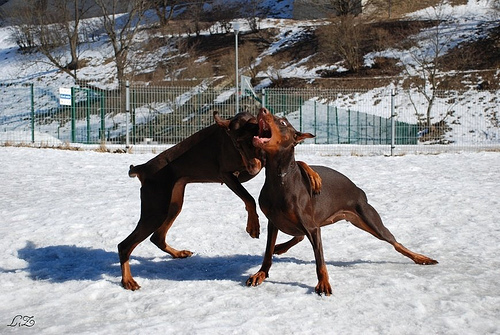

In [88]:
ex_id = '3385593926_d3e9c21170.jpg'

captions_ex = get_captions(ex_id)

print('Original Caption : ')
for sentence in captions_ex:
    print(' - ',sentence)
ipd.Image(os.path.join(PATH_IMAGES, ex_id))

In [86]:
print('Greedy :', greedy_predictions(ex_id[:-3]+'npy'))
res =  beam_search_predictions(ex_id[:-3]+'npy')
print('Beam Search, k=3 :', res)

Greedy : a dog is running through a field of grass
Beam Search, k=3 : a black and white dog is running through a field of dry grass


In [87]:
from nltk.translate.bleu_score import sentence_bleu

for sentence in captions_ex : 
    reference = [sentence]
    candidate = res
    print(sentence, '\n', res)
    score = sentence_bleu(reference, candidate)
    print('BLUE SCORE :',score, '\n')

the dogs are in the snow in front of a fence 
 a black and white dog is running through a field of dry grass
BLUE SCORE : 0.20022111856297908 

the dogs play on the snow 
 a black and white dog is running through a field of dry grass
BLUE SCORE : 0.11127177976187139 

two brown dogs playfully fight in the snow 
 a black and white dog is running through a field of dry grass
BLUE SCORE : 0.1156436343718771 

two brown dogs wrestle in the snow 
 a black and white dog is running through a field of dry grass
BLUE SCORE : 0.09471632965144829 

two dogs playing in the snow 
 a black and white dog is running through a field of dry grass
BLUE SCORE : 0.13149029125998113 



Original Caption : 
 -  a man is wearing a sooners red football shirt and helmet
 -  a oklahoma sooners football player wearing his jersey number 28
 -  a sooners football player the number 28 and black armbands
 -  guy in red and white football uniform
 -  the american footballer is wearing a red and white strip


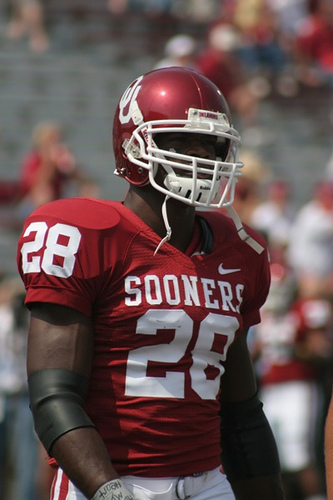

In [89]:
ex_id = '241347760_d44c8d3a01.jpg'

captions_ex = get_captions(ex_id)

print('Original Caption : ')
for sentence in captions_ex:
    print(' - ',sentence)
ipd.Image(os.path.join(PATH_IMAGES, ex_id[:-3]+'jpg'))

In [90]:
print('Greedy :', greedy_predictions(ex_id[:-3]+'npy'))
res =  beam_search_predictions(ex_id[:-3]+'npy')
print('Beam Search, k=3 :', res)

Greedy : a football player in a sooners jersey is running on the ice
Beam Search, k=3 : a football player in a sooners jersey is running on the ice


In [91]:
for sentence in captions_ex : 
    reference = [sentence]
    candidate = res
    print(sentence, '\n', res)
    score = sentence_bleu(reference, candidate)
    print('BLUE SCORE :',score, '\n')

a man is wearing a sooners red football shirt and helmet 
 a football player in a sooners jersey is running on the ice
BLUE SCORE : 0.4647893224891869 

a oklahoma sooners football player wearing his jersey number 28 
 a football player in a sooners jersey is running on the ice
BLUE SCORE : 0.5955212046805138 

a sooners football player the number 28 and black armbands 
 a football player in a sooners jersey is running on the ice
BLUE SCORE : 0.5227489469245544 

guy in red and white football uniform 
 a football player in a sooners jersey is running on the ice
BLUE SCORE : 0.25893663258774086 

the american footballer is wearing a red and white strip 
 a football player in a sooners jersey is running on the ice
BLUE SCORE : 0.35979140124385994 



Original Caption : 
 -  a brown dog jumping off a rock into a lake
 -  a brown dog leaps into water from a rock
 -  a dog is taking a dive into a body of water
 -  a dog leaps over the water from a rock
 -  the dog is leaping into the water


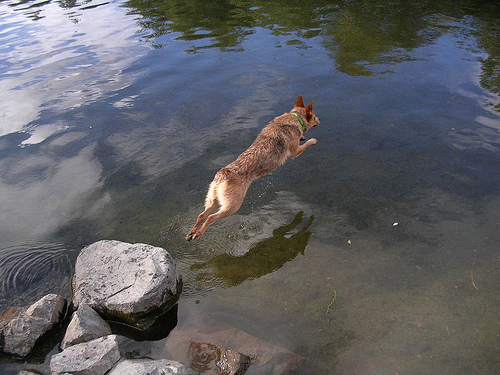

In [92]:
ex_id = '3040033126_9f4b88261b.jpg'

captions_ex = get_captions(ex_id)

print('Original Caption : ')
for sentence in captions_ex:
    print(' - ',sentence)
ipd.Image(os.path.join(PATH_IMAGES, ex_id[:-3]+'jpg'))

In [93]:
print('Greedy :', greedy_predictions(ex_id[:-3]+'npy'))
res =  beam_search_predictions(ex_id[:-3]+'npy')
print('Beam Search, k=3 :', res)

Greedy : a dog is running through the water
Beam Search, k=3 : a white dog is jumping into the water


In [94]:
for sentence in captions_ex : 
    reference = [sentence]
    candidate = res
    print(sentence, '\n', res)
    score = sentence_bleu(reference, candidate)
    print('BLUE SCORE :',score, '\n')

a brown dog jumping off a rock into a lake 
 a white dog is jumping into the water
BLUE SCORE : 0.40340418876930806 

a brown dog leaps into water from a rock 
 a white dog is jumping into the water
BLUE SCORE : 0.35947454115584915 

a dog is taking a dive into a body of water 
 a white dog is jumping into the water
BLUE SCORE : 0.4493739006396587 

a dog leaps over the water from a rock 
 a white dog is jumping into the water
BLUE SCORE : 0.3769067702313552 

the dog is leaping into the water 
 a white dog is jumping into the water
BLUE SCORE : 0.7198291745091535 



## 3. Analysis 

Let's take a look closer to the BLUE score. We want to see how it can vary across the test sample. To do so, we will compute the BLUE score of our prediction against the 5 ground truth sentences and keep the best one (indeed, we only need to see if the generated sentence can be close to one of the ground truth one, as we want to see if the genetated sentence can be use a caption written by humans. Only one is necessary then).

In [121]:
#results = []

for ex_id in tqdm_notebook(test_images[100:200]):
    captions_ex = get_captions(ex_id)
    res =  beam_search_predictions(ex_id[:-3]+'npy')
    max_score = 0
    ind_max = 0
    for i,sentence in enumerate(captions_ex) : 
        reference = [sentence]
        candidate = res
        score = sentence_bleu(reference, candidate)
        if score > max_score :
            ind_max = i
            max_score = score
    results.append([ex_id, ind_max, max_score])
    

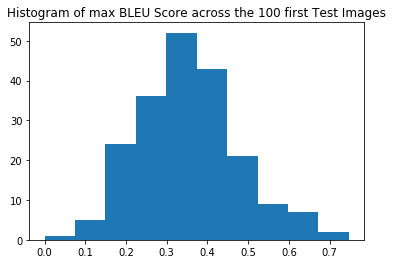

In [122]:
blue_score = [res[2] for res in results]
plt.title('Histogram of max BLEU Score across the 100 first Test Images')
plt.hist(blue_score, bins=10)
plt.show()

In [123]:
ind_max = np.argmax(np.array(results)[:,2].astype('float'))
ind_min = np.argmin(np.array(results)[:,2].astype('float'))

## Image with max BLEU score

Predicted Caption a black and white dog is running through the grass with a stick in its mouth
Original Caption : 
 -  a dog is running with a yellow tennis ball and wearing a red harness
 -  a small black and white dog running through the grass with a tennis ball in his mouth
 -  small black and white dog wearing a red harness is running around with a ball in its mouth
 -  small dog with red harness fetching a ball
 -  the dog wearing the red collar is running across the grass with a ball in its mouth


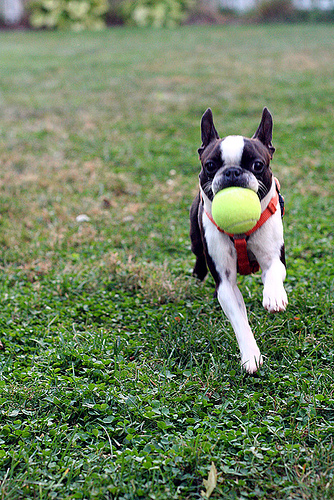

In [124]:
ex_id = test_images[ind_max]

captions_ex = get_captions(ex_id)
print('Predicted Caption',beam_search_predictions(ex_id[:-3]+'npy'))
print('Original Caption : ')
for sentence in captions_ex:
    print(' - ',sentence)
ipd.Image(os.path.join(PATH_IMAGES, ex_id[:-3]+'jpg'))

## Image with min BLEU score

Predicted Caption a little girl in a pink shirt is standing on a stone wall
Original Caption : 
 -  a long haired drummer plays music outdoors
 -  a man with long hair and tattoos plays a drum outdoors
 -  a musician plays a drum while his hair covers his face and tattoos dot his arms
 -  a person shakes their hair and a drum
 -  the drummer the drums at an outdoor concert


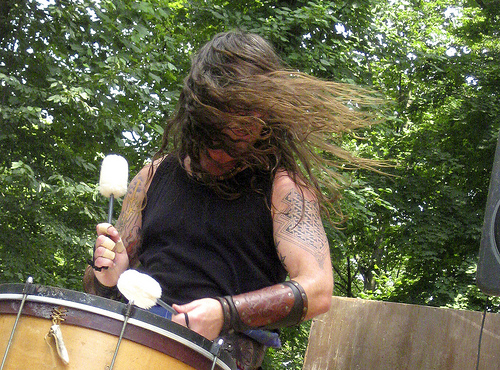

In [125]:
ex_id = test_images[ind_min]

captions_ex = get_captions(ex_id)
print('Predicted Caption',beam_search_predictions(ex_id[:-3]+'npy'))
print('Original Caption : ')
for sentence in captions_ex:
    print(' - ',sentence)
ipd.Image(os.path.join(PATH_IMAGES, ex_id[:-3]+'jpg'))